Test Notebook for Antibody Similarity Graphing

In [1]:
import itertools
import os

import adjustText

from dms_variants.constants import CBPALETTE

from IPython.display import display, HTML

import matplotlib
import matplotlib.pyplot as plt

import numpy

import pandas as pd

import seaborn

import sklearn.manifold

import yaml

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [3]:
os.makedirs(config['escape_profiles_dir_ZIKV'], exist_ok=True)

In [4]:
site_metric = config['site_metric']
mut_metric = config['mut_metric']

print(f"At site level, quantifying selection by {site_metric}")
print(f"At mutation level, quantify selection by {mut_metric}")

At site level, quantifying selection by site_total_escape_frac_single_mut
At mutation level, quantify selection by mut_escape_frac_single_mut


In [5]:
print(f"Reading escape fractions from {config['escape_fracs_ZIKV']}")
escape_fracs = (pd.read_csv(config['escape_fracs_ZIKV'])
                .query('library == "average"')
                .drop(columns=['site', 'selection', 'library'])
                .rename(columns={'label_site': 'site'})
                )
print('First few lines of escape-fraction data frame:')
display(HTML(escape_fracs.head().to_html(index=False)))

Reading escape fractions from results/escape_scores/escape_fracs_ZIKV.csv
First few lines of escape-fraction data frame:


condition,site,wildtype,mutation,protein_chain,protein_site,mut_escape_frac_single_mut,site_total_escape_frac_single_mut,site_avg_escape_frac_single_mut,nlibs,n_single_mut_measurements
Z2029_1000,299,R,C,E,299,0.045830,0.1132,0.02831,1,1
Z2029_1000,299,R,K,E,299,0.016530,0.1132,0.02831,1,1
Z2029_1000,299,R,L,E,299,0.050610,0.1132,0.02831,1,1
Z2029_1000,299,R,N,E,299,0.000266,0.1132,0.02831,1,1
Z2029_1000,300,L,C,E,300,0.028570,0.1163,0.03878,1,1


In [12]:
print(f"Reading escape-profile configuration from {config['escape_profiles_config_ZIKV']}")
with open(config['escape_profiles_config_ZIKV']) as f:
    escape_profiles_config = yaml.safe_load(f)
    
print(f"Reading the site color schemes from {config['site_color_schemes']}")
site_color_schemes = pd.read_csv(config['site_color_schemes'])

Reading escape-profile configuration from data/escape_profiles_config_ZIKV.yaml
Reading the site color schemes from data/site_color_schemes.csv


In [13]:
def escape_similarity(df, p=1):
    """Compute similarity between all pairs of conditions in `df`."""
    df = df[['condition', 'site', site_metric]].drop_duplicates()
    assert not df.isnull().any().any()
    
    conditions = df['condition'].unique()
    similarities = []
    for cond1, cond2 in itertools.product(conditions, conditions):
        similarity = (
            df
            .assign(metric=lambda x: x[site_metric]**p)
            .pivot_table(index='site', columns='condition', values='metric')
            [list({cond1, cond2})]
            # for normalization: https://stackoverflow.com/a/58113206
            # to get norm: https://stackoverflow.com/a/47953601
            .transform(lambda x: x / numpy.linalg.norm(x, axis=0))
            .assign(similarity=lambda x: x[cond1] * x[cond2])
            ['similarity']
            .sum()
            )
        similarities.append(similarity)
    return pd.DataFrame(numpy.array(similarities).reshape(len(conditions), len(conditions)),
                        columns=conditions, index=conditions)

In [14]:
def dissimilarity(similarity, method='one_minus'):
    if method == 'one_minus':
        return 1 - similarity
    elif method == 'minus_log':
        return -numpy.log(similarity)
    else:
        raise ValueError(f"invalid `method` {method}")


Making plot MAP_paper_antibodies, which has the following antibodies:
['Z2131_1000', 'Z6161_1000', 'Z6163_1000', 'Z3039_1000', 'Z2029_1000', 'Z2039_1000', 'Z2044_1000', 'Z2103_1000', 'Z3051_1000', 'Z2212_1000', 'Z2102_1000', 'Z2208_1000', 'Z3022_1000', 'Z6147_1000', 'ZV67_1000']


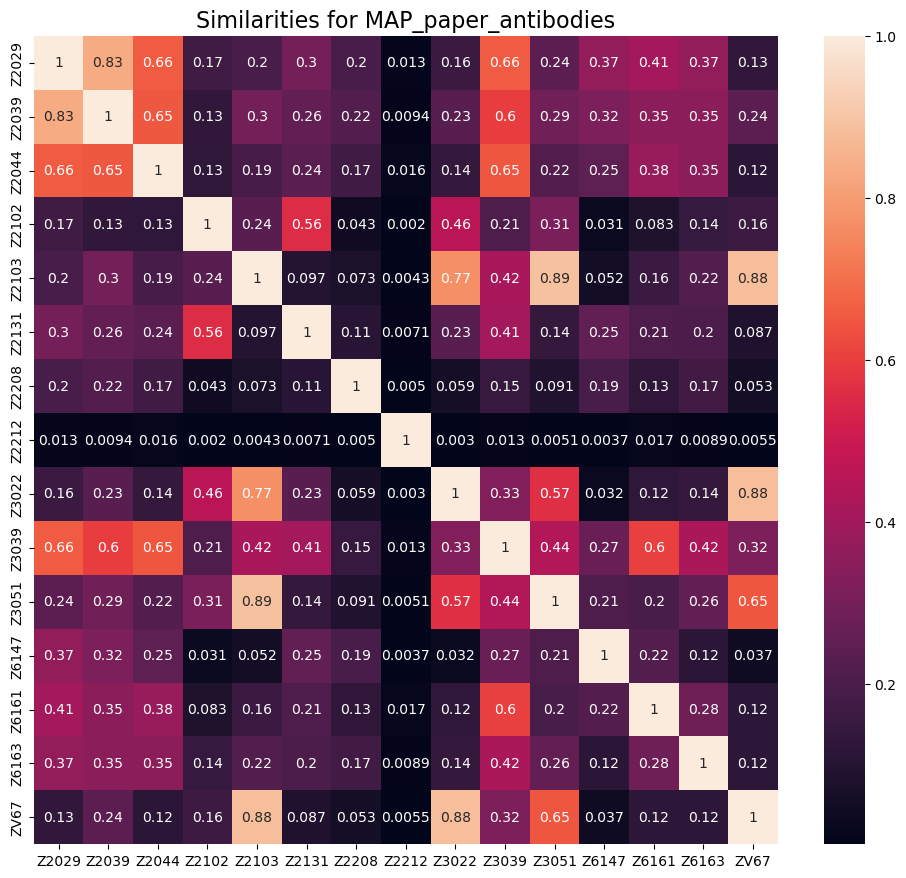

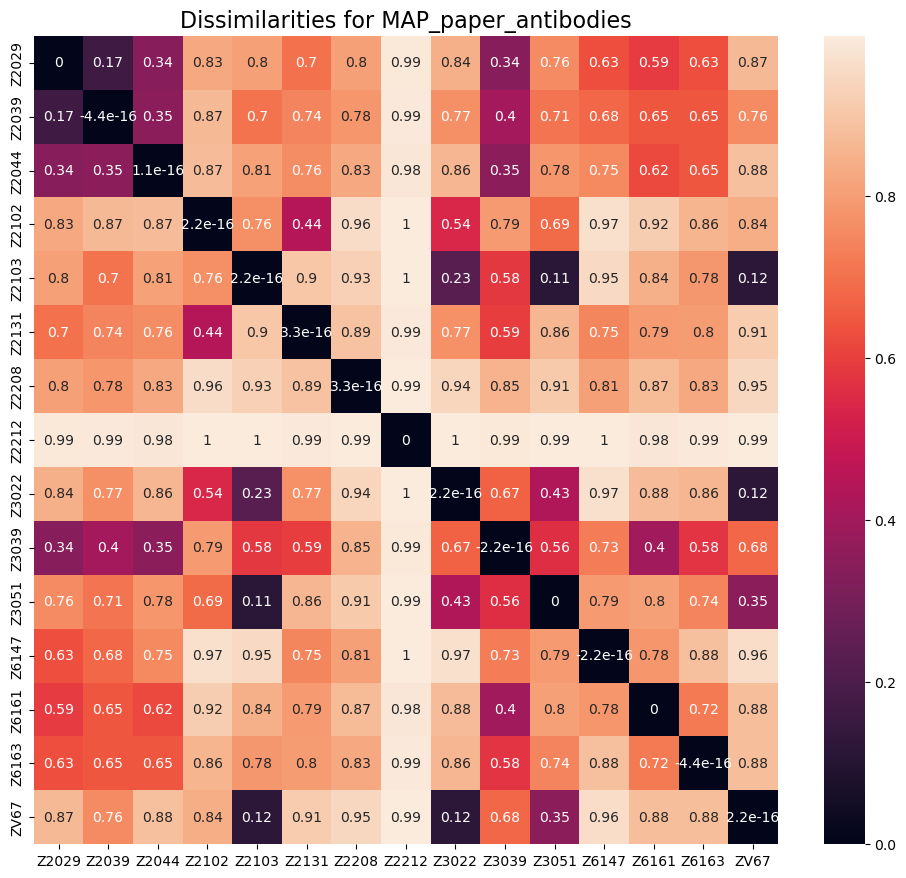

/project/jdbr310_uksr/ilta223/my_conda/Tyler-escape/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Saving plot to results/escape_profiles/ZIKV/MAP_paper_antibodies_mds.pdf


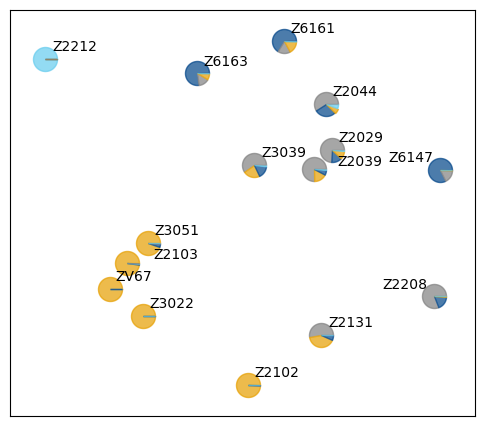

In [16]:
# which method do we use to compute dissimilarity?
dissimilarity_method = 'one_minus'

# parameterize visual appearance / prettiness for this plot
random_state=4
pie_size=300
alpha=0.7
expand_points=(1.3, 1.7)

# function to draw colored pie for each point.
def draw_pie(dist, xpos, ypos, size, ax, colors):
    """Based on this: https://stackoverflow.com/q/56337732"""
    # for incremental pie slices
    cumsum = numpy.cumsum(dist)
    cumsum = cumsum / cumsum[-1]
    pie = [0] + cumsum.tolist()

    assert len(colors) == len(dist)
    for r1, r2, color in zip(pie[:-1], pie[1:], colors):
        angles = numpy.linspace(2 * numpy.pi * r1, 2 * numpy.pi * r2)
        x = [0] + numpy.cos(angles).tolist()
        y = [0] + numpy.sin(angles).tolist()

        xy = numpy.column_stack([x, y])

        ax.scatter([xpos], [ypos], marker=xy, s=size, color=color, alpha=alpha)

    return ax

# loop over combinations to plot
for name, specs in escape_profiles_config.items():
    
    # do we make a plot for this set of antibodies according to escape profile config
    if 'mds' not in specs or not specs['mds']:
        continue
    
    # get data frame with just the conditions we want to plot, also re-naming them
    conditions_to_plot = list(specs['conditions'].keys())
    print(f"\nMaking plot {name}, which has the following antibodies:\n{conditions_to_plot}")
    assert len(conditions_to_plot) == len(set(specs['conditions'].values()))
    assert set(conditions_to_plot).issubset(set(escape_fracs['condition']))
    df = (escape_fracs
          .query('condition in @conditions_to_plot')
          .assign(condition=lambda x: x['condition'].map(specs['conditions']))
          )
    
    # compute similarities and dissimilarities
    similarities = escape_similarity(df)
    dissimilarities = similarities.applymap(lambda x: dissimilarity(x, method=dissimilarity_method))
    
    # plot similarities and dissimilarities
    conditions = df['condition'].unique()
    assert all(conditions == similarities.columns) and all(conditions == similarities.index)
    n = len(conditions)
    for title, data in [('Similarities', similarities), ('Dissimilarities', dissimilarities)]:
        fig, ax = plt.subplots(figsize=(0.8 * n, 0.7 * n))
        _ = seaborn.heatmap(data, annot=True, ax=ax)
        plt.title(f"{title} for {name}", size=16)
        plt.show(fig)
        plt.close(fig)
    
    # use multidimensional scaling to get locations of antibodies
    mds = sklearn.manifold.MDS(n_components=2,
                               metric=True,
                               max_iter=3000,
                               eps=1e-6,
                               random_state=random_state,
                               dissimilarity='precomputed',
                               n_jobs=1)
    locs = mds.fit_transform(dissimilarities)
    
    # get the colors for each point if relevant
    if 'mds_color_by_site' in specs and specs['mds_color_by_site']:
        assert 'site_color_scheme' in specs, 'no site-color scheme specified'
        site_colors = site_color_schemes.set_index('site')[specs['site_color_scheme']].to_dict()
        df = df.assign(color=lambda x: x['site'].map(site_colors))
        dists = []
        colors = []
        for condition, condition_df in (
                df
                [['condition', 'color', 'site', site_metric]]
                .drop_duplicates()
                .assign(site_metric2=lambda x: x[site_metric]**2)  # color in proportion to **square** of site escape
                .groupby(['condition', 'color'])
                .aggregate(tot_escape=pd.NamedAgg('site_metric2', 'sum'))
                .reset_index()
                .sort_values('tot_escape', ascending=False)
                .assign(condition=lambda x: pd.Categorical(x['condition'], conditions, ordered=True))
                .groupby('condition', sort=True)
                ):
            dists.append(condition_df['tot_escape'].tolist())
            colors.append(condition_df['color'].tolist())
    else:
        dists = [[1] for conditition in conditions]
        colors = [['#1f77b4'] for condition in conditions]
    
    # plot the multidimensional scaling result
    fig, ax = plt.subplots(figsize=(6, 6))
    xs = locs[:, 0]
    ys = locs[:, 1]
    for x, y, dist, color in zip(xs, ys, dists, colors):
        draw_pie(dist, x, y, size=pie_size, ax=ax, colors=color)
    ax.set_aspect('equal', adjustable='box')  # same distance on both axes
    ax.set_xticks([])  # no x-ticks
    ax.set_yticks([])  # no y-ticks
    ax.margins(0.09)  # increase padding from axes
    texts = [plt.text(x, y, label, color='black') for x, y, label in zip(xs, ys, conditions)]
    adjustText.adjust_text(texts,
                           x=xs,
                           y=ys,
                           expand_points=expand_points,
                           )
    plotfile = os.path.join(config['escape_profiles_dir_ZIKV'], f"{name}_mds.pdf")
    print(f"Saving plot to {plotfile}")
    fig.savefig(plotfile, bbox_inches='tight')
    plt.show(fig)
    plt.close(fig)